# Splot - Exploring Spatial Autocorrelation

Content:
1. Imports
2. Statistical data pre-processing
3. Lisa cluster map functionality
    * mask_local_auto()
    * lisa_cluster()
4. Splot - Plotting
    * Three plot visualization examining single values/ areas
    * Three plot visualization masking quadrant values in maps
    * Static three plot visualization for printing

## Imports

In [11]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pysal as ps
import libpysal.api as lp
from libpysal import examples
import numpy as np
import geopandas as gpd
import os
import splot
import splot.plot
import esda
from pysal.contrib.pdio import read_files

In [8]:
from importlib import reload

reload(splot.plot)

<module 'splot.plot' from '/Users/steffie/code/splot/splot/plot.py'>

## Example Data

First, we will load the Guerry.shp data from the example_data folder.

In [13]:
link = examples.get_path('columbus.shp')
df = gpd.read_file(link)

For this example we will focus on the Donatns (charitable donations per capita) variable. We will calculate Contiguity weights `w` with `ps.queen_from_shapefile()`. Then we transform our weights to be row-standardized. Lastly we calculate moran and moran_loc values, used as input for the visualizations.

In [14]:
y = df['HOVAL'].values
w = lp.Queen.from_dataframe(df)
w.transform = 'r'

moran_loc = esda.moran.Moran_Local(y, w)

We would now like to visually explore our data for specific regions. Region names are stored under `Dprtmnt` in our dataframe. 

In [15]:
region = df['POLYID']
region.head()

0    1
1    2
2    3
3    4
4    5
Name: POLYID, dtype: int64

### In order to load the three-plot visualization we need to load the new lisa_cluster functionality

In [16]:
def mask_local_auto(moran_loc, df=None, p=0.5):
    '''
    Create Mask for coloration and labeling of local spatial autocorrelation
    
    Parameters
    ----------
    moran_loc : esda.moran.Moran_Local instance
        values of Moran's I Global Autocorrelation Statistic
    df : geopandas dataframe instance, optional
        If given, assign df['labels'] per row.  Note that `df` will be
        modified, so calling functions should use a copy of the user
        provided `df`.
    p : float
        The p-value threshold for significance. Points will
        be colored by significance.
    
    Returns
    -------
    cluster_labels : list of str
        List of labels - ['ns', 'HH', 'LH', 'LL', 'HL']
    colors5 : list of str
        List of colours - ['lightgrey', 'red', 'lightskyblue', 'mediumblue', 'pink']
    colors : array of str
        Array containing coloration for each input value/ shape.
    '''
    # create a mask for local spatial autocorrelation
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q==1)
    LL = 3 * (sig * moran_loc.q==3)
    LH = 2 * (sig * moran_loc.q==2)
    HL = 4 * (sig * moran_loc.q==4)

    cluster = HH + LL + LH + HL
    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    # create a new column with label info
    if df is not None:
        df['labels'] = np.array(labels)

    #colors5 = (['lightgrey', 'red', 'lightskyblue', 'mediumblue', 'pink'])
    colors5 = (['red', 'pink', 'lightblue', 'blue', 'lightgrey'])
    colors = [colors5[i] for i in cluster]
    
    return cluster_labels, colors5, colors, labels


In [17]:
cluster_labels, colors5, colors, labels = mask_local_auto(moran_loc, df=None, p=0.5)
print(colors5)

['red', 'pink', 'lightblue', 'blue', 'lightgrey']


In [18]:
def lisa_cluster(moran_loc, df, p=0.05, figsize=None, ax=None,
                 legend=True, legend_kwds=None):
    """
    Create a LISA Cluster map
    
    Parameters
    ----------
    moran_loc : esda.moran.Moran_Local instance
        Values of Moran's I Global Autocorrelation Statistic
    df : geopandas dataframe instance, optional
        If given, assign df['labels'] per row.  Note that `df` will be
        modified, so calling functions should use a copy of the user
        provided `df`.
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    figsize: tuple, optional
        W, h of figure. Default = None
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout. Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options.
        Example ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
        
    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map 
    """
    # imports
    import geopandas as gdp
    from matplotlib import colors
    
    # retrieve colors5 and labels from mask_local_auto
    _, colors5, _, labels = mask_local_auto(moran_loc, p=p, df=df)
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5)
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    df.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend=legend, legend_kwds=legend_kwds)
    ax.set_axis_off()
    
    return fig

#### Example:

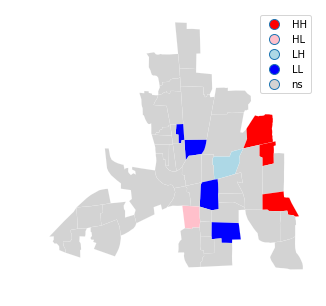

In [19]:
lisa_cluster(moran_loc, df, p=0.05, figsize = (5,5))

plt.show()

## Visualizing Local Autocorrelation with splot - exploring specific regions

In [31]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from geopandas.plotting import plot_dataframe
from importlib import reload
reload(splot)

def plot_local_autocorrelation(m, df, attribute, p=0.05, region_column=None,
                               mask=None, mask_color='gold', quadrant=None,
                               figsize=(15, 4), legend=True, scheme='Quantiles', cmap='GnBu'):
    '''
    Produce three-plot visualization with region mask
    
    Parameters
    ----------
    m : esda.moran.Moran_Local instance
        Values of Moran's Local Autocorrelation Statistic
    df : geopandas dataframe
        The Dataframe containing information to plot the two maps.
    attribute : str
        Column name of attribute which should be depicted in Choropleth map.
    p : float, optional
        The p-value threshold for significance. Points and polygons will
        be colored by significance. Default = 0.05.
    region_column: string, optional
        Column name containing mask region of interest. Default = None
    mask: str, optional
        Identifier or name of the region to highlight. Default = None
    mask_color: str, optional
        Color of mask. Default = 'gold'
    quadrant : int, optional
        Quadrant 1-4 in scatterplot masking values in LISA cluster and
        Choropleth maps. Default = None
    figsize: tuple, optional
        W, h of figure. Default = (15,4)
    legend: boolean, optional
        If True, legend for maps will be depicted. Default = True
    scheme: str, optional
        Name of PySAL classifier to be used. Default = 'Quantiles'
    cmap: str, optional
        Name of matplotlib colormap used for plotting the Choropleth. Default = 'GnBU'
    
    Returns
    -------
    fig : Matplotlib figure instance
        Moran Scatterplot, LISA cluster map and Choropleth
    
        '''
    fig, axs = plt.subplots(1, 3, figsize=figsize,
                            subplot_kw={'aspect':'equal'})
    #Moran Scatterplot
    splot.plot.mplot(m, xlabel='Response', ylabel='Spatial Lag',
                     title='Moran Scatterplot', p=p, ax=axs[0])
    axs[0].set_aspect('auto')
    
    # Lisa cluster map
    #TODO: Fix legend_kwds: display boxes instead of points, 
    lisa_cluster(m, df, p=p, ax=axs[1], legend=legend,
                     legend_kwds={'loc': 'upper left', 
                    'bbox_to_anchor': (0.92, 1.05)})
    
    #Choropleth for attribute
    df.plot(column=attribute, scheme=scheme, cmap=cmap,
            legend=legend, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}, ax=axs[2], alpha=1)
    axs[2].set_axis_off()
    
    # REGION MASKING
    if region_column is not None:
        # masking inside axs[0] or Moran Scatterplot
        ix = df[region_column].isin(mask)
        df_mask = df[ix]
        x_mask = m.z[ix]
        y_mask = ps.lag_spatial(m.w, m.z)[ix]
        axs[0].plot(x_mask, y_mask, color=mask_color, marker='o', markersize=14,
                    alpha=.8, zorder=-1)
        
        
        #masking inside axs[1] or Lisa cluster map
        union = df_mask.unary_union.boundary
        gpd.GeoSeries([union]).plot(linewidth=2, ax=axs[1], color=mask_color)
        
        #masking inside axs[2] or Chloropleth
        gpd.GeoSeries([union]).plot(linewidth=2, ax=axs[2], color=mask_color)
    
    #MASKING QUADRANT VALUES
    if quadrant is not None:
        #Quadrant masking in Scatterplot
        mask_angles = {1: 0, 2: 90, 3: 180, 4: 270} #rectangle angles
        axs[0].add_patch(patches.Rectangle((0,0), width=50, height=50, angle=mask_angles[quadrant],
                                           color='grey', zorder=-1, alpha=0.8))
        # quadrant selection in maps
        non_quadrant = ~(m.q==quadrant)
        mask_quadrant = df[non_quadrant]
        df_quadrant = df.iloc[m.q == quadrant] 
        union2 = df_quadrant.unary_union.boundary
        
        # LISA Cluster mask and cluster boundary
        mask_quadrant.plot(column=attribute, scheme=scheme, color='white', ax=axs[1], alpha=0.7, zorder=1)
        gpd.GeoSeries([union2]).plot(linewidth=2, ax=axs[1], color='darkgrey')
        
        #CHOROPLETH MASK
        mask_quadrant.plot(column=attribute, scheme=scheme, color='white', ax=axs[2], alpha=0.7, zorder=1)
        gpd.GeoSeries([union2]).plot(linewidth=2, ax=axs[2], color='darkgrey')
        
    return fig

Now, exlpore values for different regions in France, e.g. 'Rhone', 'Hautes-Alpes', ...

In [29]:
df['POLYID'].head()

0    1
1    2
2    3
3    4
4    5
Name: POLYID, dtype: int64

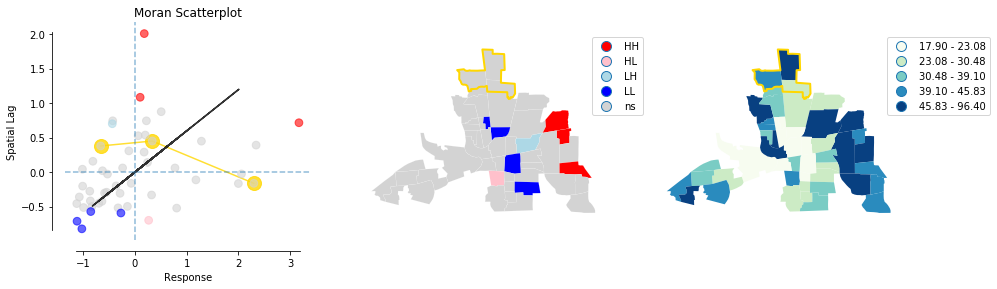

In [34]:
plot_local_autocorrelation(moran_loc, df, "HOVAL", region_column='POLYID', mask=['1', '2', '3'], legend=True)

plt.show()

Where are regions which are not significant, but still localted in the first quadrant?
Try different other quadrants

/Users/steffie/code/geopandas/geopandas/plotting.py:385: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


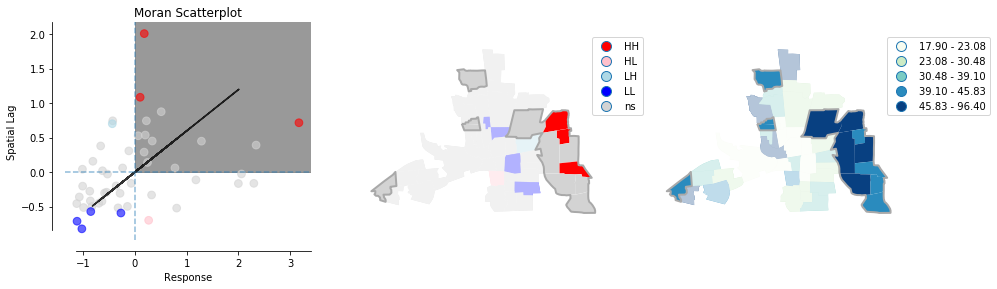

In [24]:
plot_local_autocorrelation(moran_loc, df, "HOVAL", legend=True, quadrant=1)

plt.show()

Print your findings in a publication:

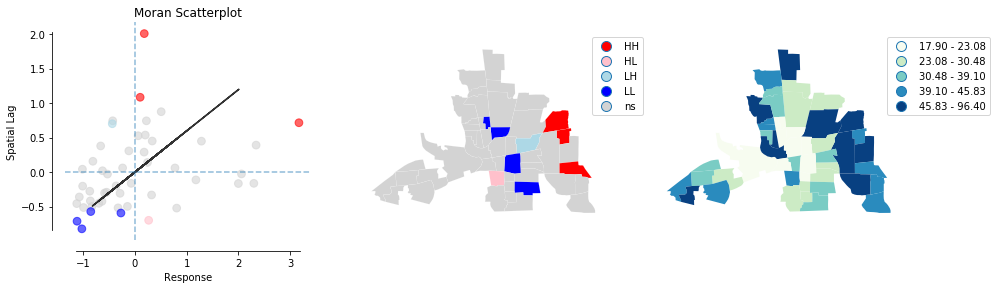

In [25]:
plot_local_autocorrelation(moran_loc, df, "HOVAL", legend=True)
plt.show()

## TESTS

In [45]:
import matplotlib.pyplot as plt
import libpysal.api as lp
from libpysal import examples
from esda.moran import Moran_Local
from libpysal.io.geotable import read_files
import geopandas as gpd

import splot


def test_lisa_cluster():
    link = examples.get_path('columbus.shp')
    df = gpd.read_file(link)

    y = df['HOVAL'].values
    w = lp.Queen.from_dataframe(df)
    w.transform = 'r'

    moran_loc = esda.moran.Moran_Local(y, w)

    fig = lisa_cluster(moran_loc, df)
    
    plt.close(fig)

In [33]:
import matplotlib.pyplot as plt
import libpysal.api as lp
from libpysal import examples
from esda.moran import Moran_Local
from libpysal.io.geotable import read_files
import geopandas as gpd

import splot

def test_plot_local_auto():
    link = examples.get_path('columbus.shp')
    df = gpd.read_file(link)

    y = df['HOVAL'].values
    w = lp.Queen.from_dataframe(df)
    w.transform = 'r'

    moran_loc = esda.moran.Moran_Local(y, w)

    fig = plot_local_autocorrelation(moran_loc, df, y, p=0.05)
    plt.close(fig)
    
    # also test with quadrant and mask
    fig = plot_local_autocorrelation(moran_loc, df, y, p=0.05, region_column='POLYID',
                               mask=['1', '2', '3'], quadrant=1)
    plt.close(fig)